In [1]:
!pip install -Uqq fastbook
!pip install torchsummary

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchsummary import summary
from fastbook import *

import os
import psutil

import numpy as np
import time
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
DATA_PATH = untar_data(URLs.IMAGEWOOF_160) # PATH TO THE DATASET
NUM_WORKERS = psutil.cpu_count()
SIZE_H = SIZE_W = 160
NUM_CLASSES = 10
EPOCH_NUM = 10
BATCH_SIZE = 256

image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

EMBEDDING_SIZE = 128

In [4]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)

In [6]:
n_train, n_val = len(train_dataset), len(val_dataset)
print('train: ', n_train)
print('val  : ', n_val)

train:  9025
val  :  3929


In [7]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS)
train_batch_gen.dataset.classes

['n02086240',
 'n02087394',
 'n02088364',
 'n02089973',
 'n02093754',
 'n02096294',
 'n02099601',
 'n02105641',
 'n02111889',
 'n02115641']

In [8]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(16,12)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] 
        # and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

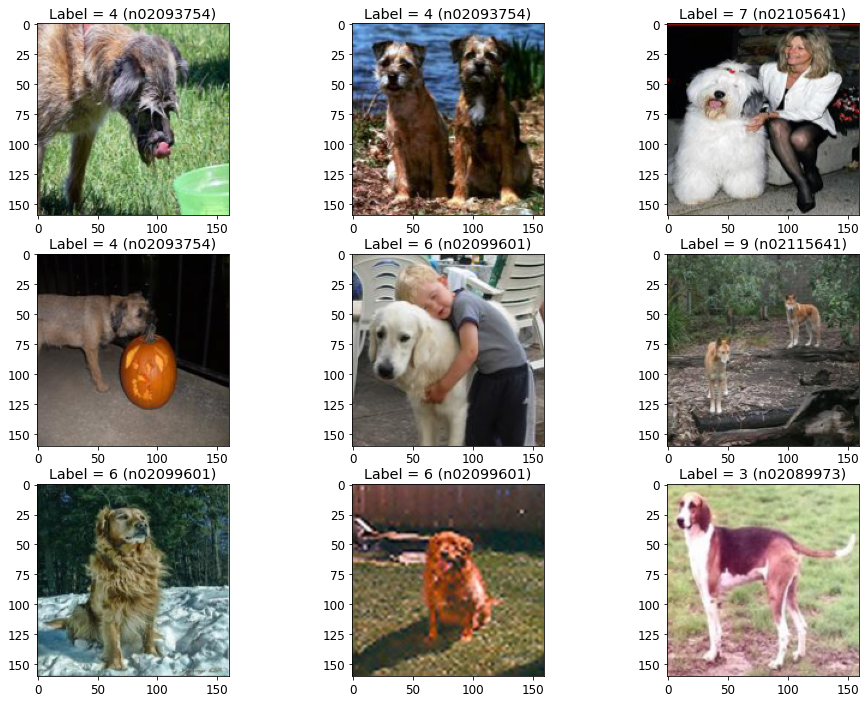

In [9]:
plot_from_batch_generator(train_batch_gen)

In [10]:
# converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x, start_dim=1)

In [11]:
loss_function = nn.CrossEntropyLoss()

def compute_loss(model, data_batch):
    """ Compute the loss using loss_function for the batch of data 
        and return mean loss value for this batch."""
        
    # load the data
    img_batch = data_batch['img']
    label_batch = data_batch['label']
    
    # forward pass
    logits = model(img_batch)
    
    # loss computation
    loss = loss_function(logits, label_batch)
    
    return loss, model

In [12]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def accuracy(scores, labels):
    assert type(scores) is np.ndarray and type(labels) is np.ndarray
    return accuracy_score(labels, scores)

def f1(scores, labels):
    assert type(scores) is np.ndarray and type(labels) is np.ndarray
    return f1_score(labels, scores, average='macro')

tracked_metrics = {
    'accuracy': accuracy,
    'f1-score': f1
}

def calculate_metrics(scores, labels, print_log=False):
    """ Compute all the metrics from tracked_metrics dict using scores and labels."""
    
    assert len(labels) == len(scores), print('Label and score lists are of different size')
    
    scores_array = np.array(scores).astype(np.float32)
    labels_array = np.array(labels)
    
    metric_results = {}
    for k,v in tracked_metrics.items():
        metric_value = v(scores_array, labels_array)
        metric_results[k] = metric_value
    
    if print_log:
        print(' | '.join(['{}: {:.4f}'.format(k,v) for k, v in metric_results.items()]))
    
    return metric_results

In [13]:
@torch.no_grad()
def test_model(model, batch_generator, subset_name='val', print_log=True, plot_scores=False):
    """ Evaluate the model using data from batch_generator and metrics defined above."""
    
    # disable dropout / use averages for batch_norm
    model.train(False)
    
    # save scores, labels and loss values for performance logging
    score_list = []
    label_list = []
    loss_list = []
    
    for X_batch, y_batch in batch_generator:
        
        # do the forward pass
        logits = model(X_batch.to(device))
        scores = logits.argmax(axis=1)
        labels = y_batch.numpy().tolist()
        
        # compute loss value
        loss = loss_function(logits, y_batch.to(device))
        
        # save the necessary data
        loss_list.append(loss.detach().cpu().numpy().tolist())
        score_list.extend(scores)
        label_list.extend(labels)
    
    if print_log:
        print("Results on {} set | ".format(subset_name), end='')
    
    metric_results = calculate_metrics(score_list, label_list, print_log)
    metric_results['scores'] = score_list
    metric_results['labels'] = label_list
    metric_results['loss'] = loss_list
    
    return metric_results

In [14]:
from IPython.display import clear_output

def train_model(model, train_batch_generator, val_batch_generator, opt, ckpt_name=None, n_epochs=EPOCH_NUM, visualize=True):
    """
    Run training: forward/backward pass using train_batch_generator and evaluation using val_batch_generator.
    Log performance using loss monitoring.
    """
    
    train_loss, val_loss = [], [3]
    val_loss_idx = [0]
    best_model = None
    top_val_accuracy = 0
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        # Train phase
        model.train(True)
        for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Training', leave=False):
            
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            data_batch = {'img': X_batch, 'label': y_batch}
            
            loss, model = compute_loss(model, data_batch)
            
            # compute backward pass
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            # log train loss
            train_loss.append(loss.detach().cpu().numpy())
        
        # Evaluation phase
        metric_results = test_model(model, val_batch_generator, subset_name='val')
        
        if visualize:
            clear_output()
        
        # Logging
        val_loss_value = np.mean(metric_results['loss'])
        val_loss_idx.append(len(train_loss))
        val_loss.append(val_loss_value)
        
        
        if visualize:
            plt.figure(figsize=(12,5))
  
            plt.plot(train_loss, color='b', label='train')
            plt.plot(val_loss_idx, val_loss, color='c', label='val')
            plt.legend()
            plt.title('Train/val loss.')
            
            plt.show()
            for i, n in enumerate(val_loss[1:]):
                print('validation loss {}: '.format(i + 1), round(n, 3))
        
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, n_epochs, time.time() - start_time))
        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = metric_results['accuracy']
        if val_accuracy_value > top_val_accuracy and ckpt_name is not None:
            top_val_accuracy = val_accuracy_value
            
            # save checkpoint of the best model to disk
            with open(ckpt_name, 'wb') as f: torch.save(model, f)
        
    return model, opt

In [15]:
model_cnn = nn.Sequential()


model_cnn.add_module('conv1', nn.Conv2d(3, 32, 3, stride=1, padding=1))
model_cnn.add_module('relu1', nn.ReLU())
model_cnn.add_module('pool1', nn.MaxPool2d(2))
model_cnn.add_module('conv2', nn.Conv2d(32, 64, 3, stride=1, padding=1))
model_cnn.add_module('relu2', nn.ReLU())
model_cnn.add_module('pool2', nn.MaxPool2d(2))
model_cnn.add_module('conv3', nn.Conv2d(64, 128, 3, stride=1, padding=1))
model_cnn.add_module('relu3', nn.ReLU())
model_cnn.add_module('pool3', nn.MaxPool2d(2))

# global max pooling
model_cnn.add_module('global_max_pooling', nn.AdaptiveMaxPool2d(1))
# dropout for regularization
model_cnn.add_module('dropout', nn.Dropout(0.3))
# "flatten" the data
model_cnn.add_module('flat', Flatten())
# last fully-connected layer, used to create embedding vectors
model_cnn.add_module('fc', nn.Linear(128, EMBEDDING_SIZE))
model_cnn.add_module('relu', nn.ReLU())

model_cnn.add_module('dropout_6', nn.Dropout(0.3))

model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False))

In [16]:
summary(model_cnn, (3, SIZE_H, SIZE_W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 160]             896
              ReLU-2         [-1, 32, 160, 160]               0
         MaxPool2d-3           [-1, 32, 80, 80]               0
            Conv2d-4           [-1, 64, 80, 80]          18,496
              ReLU-5           [-1, 64, 80, 80]               0
         MaxPool2d-6           [-1, 64, 40, 40]               0
            Conv2d-7          [-1, 128, 40, 40]          73,856
              ReLU-8          [-1, 128, 40, 40]               0
         MaxPool2d-9          [-1, 128, 20, 20]               0
AdaptiveMaxPool2d-10            [-1, 128, 1, 1]               0
          Dropout-11            [-1, 128, 1, 1]               0
          Flatten-12                  [-1, 128]               0
           Linear-13                  [-1, 128]          16,512
             ReLU-14                  [

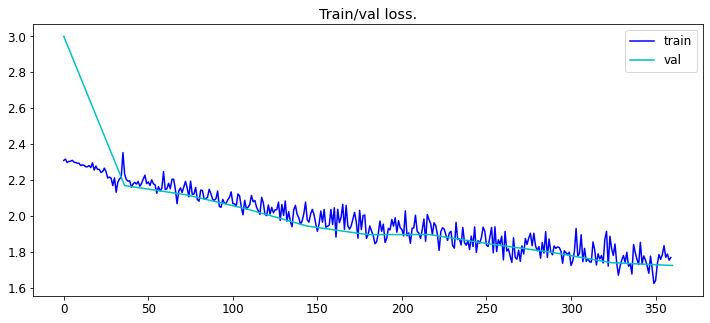

validation loss 1:  2.169
validation loss 2:  2.119
validation loss 3:  2.04
validation loss 4:  1.944
validation loss 5:  1.896
validation loss 6:  1.897
validation loss 7:  1.844
validation loss 8:  1.799
validation loss 9:  1.74
validation loss 10:  1.725
Epoch 10 of 10 took 23.160s


In [17]:
model_cnn = model_cnn.to(device)
opt = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
opt.zero_grad()
ckpt_name_cnn='model_cnn.ckpt'
model_cnn, opt = train_model(model_cnn, train_batch_gen, val_batch_gen,opt, ckpt_name=ckpt_name_cnn, n_epochs=10)

In [18]:
best_model_cnn=None
with open(ckpt_name_cnn, 'rb') as f:
    best_model_cnn = torch.load(f)

val_stats = test_model(best_model_cnn, val_batch_gen, 'val')

Results on val set | accuracy: 0.3706 | f1-score: 0.3478


In [19]:
# Custom model class

def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(

        nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class MyModel(torch.nn.Module):
    def __init__(self, in_feature):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            conv_block_3x3(in_feature, 32),
            nn.MaxPool2d(2),           
            conv_block_3x3(32, 64),
            nn.MaxPool2d(2),
            conv_block_3x3(64, 128),
            nn.AdaptiveMaxPool2d(1),
            Flatten()
        )
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Sequential(
            nn.Linear(128, EMBEDDING_SIZE),
            nn.BatchNorm1d(EMBEDDING_SIZE),
            nn.ReLU()

        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.pred(x)
        return x

In [20]:
model_cnn_norm = MyModel(3)
summary(model_cnn_norm, (3, SIZE_H, SIZE_W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 160]             896
       BatchNorm2d-2         [-1, 32, 160, 160]              64
              ReLU-3         [-1, 32, 160, 160]               0
         MaxPool2d-4           [-1, 32, 80, 80]               0
            Conv2d-5           [-1, 64, 80, 80]          18,496
       BatchNorm2d-6           [-1, 64, 80, 80]             128
              ReLU-7           [-1, 64, 80, 80]               0
         MaxPool2d-8           [-1, 64, 40, 40]               0
            Conv2d-9          [-1, 128, 40, 40]          73,856
      BatchNorm2d-10          [-1, 128, 40, 40]             256
             ReLU-11          [-1, 128, 40, 40]               0
AdaptiveMaxPool2d-12            [-1, 128, 1, 1]               0
          Flatten-13                  [-1, 128]               0
          Dropout-14                  [

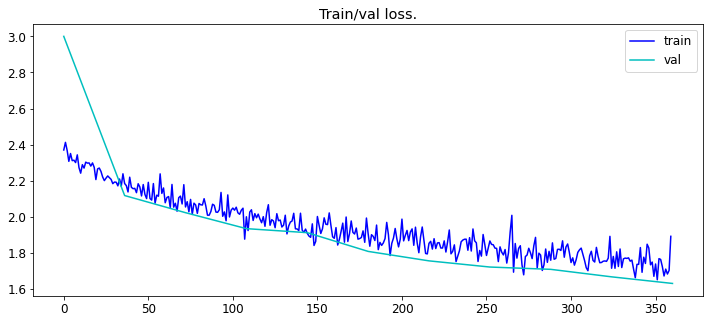

validation loss 1:  2.118
validation loss 2:  2.023
validation loss 3:  1.934
validation loss 4:  1.912
validation loss 5:  1.808
validation loss 6:  1.756
validation loss 7:  1.722
validation loss 8:  1.709
validation loss 9:  1.667
validation loss 10:  1.631
Epoch 10 of 10 took 31.951s


In [21]:
model_cnn_norm = model_cnn_norm.to(device)
opt = torch.optim.Adam(model_cnn_norm.parameters(), lr=1e-3)
ckpt_name_cnn_norm='model_cnn_norm.ckpt'
model_cnn_norm, opt = train_model(model_cnn_norm, train_batch_gen, val_batch_gen, opt, ckpt_name=ckpt_name_cnn_norm)

In [22]:
best_model_cnn_norm = None
with open(ckpt_name_cnn_norm, 'rb') as f:
    best_model_cnn_norm = torch.load(f)

val_stats = test_model(best_model_cnn_norm, val_batch_gen, 'val')

Results on val set | accuracy: 0.4032 | f1-score: 0.3725


In [23]:
# Load pre-trained model
model_resnext50 = torchvision.models.resnext50_32x4d(pretrained=True)

# Disable gradient updates for all the layers except  the final layer
for p in model_resnext50.parameters():
    p.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnext50.fc.in_features
model_resnext50.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Use available device for calculations
model_resnext50 = model_resnext50.to(device)
summary(model_resnext50, (3, SIZE_H, SIZE_W))

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           9,408
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
         MaxPool2d-4           [-1, 64, 40, 40]               0
            Conv2d-5          [-1, 128, 40, 40]           8,192
       BatchNorm2d-6          [-1, 128, 40, 40]             256
              ReLU-7          [-1, 128, 40, 40]               0
            Conv2d-8          [-1, 128, 40, 40]           4,608
       BatchNorm2d-9          [-1, 128, 40, 40]             256
             ReLU-10          [-1, 128, 40, 40]               0
           Conv2d-11          [-1, 256, 40, 40]          32,768
      BatchNorm2d-12          [-1, 256, 40, 40]             512
           Conv2d-13          [-1, 256, 40, 40]          16,384
      BatchNorm2d-14          [-1, 256,

## Training (only for final layer)

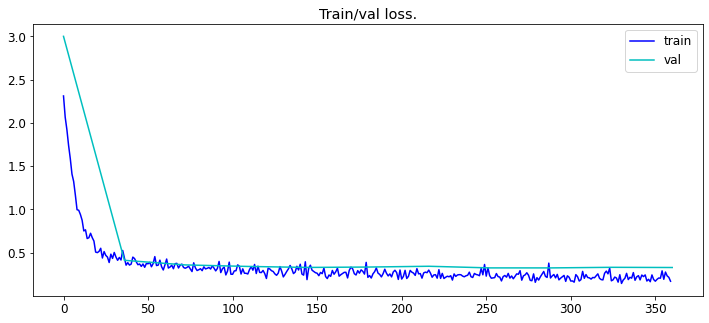

validation loss 1:  0.411
validation loss 2:  0.358
validation loss 3:  0.341
validation loss 4:  0.329
validation loss 5:  0.333
validation loss 6:  0.342
validation loss 7:  0.323
validation loss 8:  0.323
validation loss 9:  0.33
validation loss 10:  0.328
Epoch 10 of 10 took 35.441s


In [24]:
opt_resnet = torch.optim.Adam(model_resnext50.fc.parameters(), lr=1e-3)
ckpt_name_resnext50='model_resnext50_finetune.ckpt'

model_resnext50, opt_resnet = train_model(model_resnext50, train_batch_gen, val_batch_gen, opt_resnet,
                                         ckpt_name=ckpt_name_resnext50, n_epochs=10)

In [25]:
best_model_resnext50=None
with open(ckpt_name_resnext50, 'rb') as f:
    best_model_resnext50 = torch.load(f)

val_stats = test_model(best_model_resnext50, val_batch_gen, 'val')

Results on val set | accuracy: 0.8951 | f1-score: 0.8895


## Augmentation

In [26]:
transformer_augmented = transforms.Compose([
    transforms.Resize((3 * SIZE_H // 2, 3 * SIZE_W // 2)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.RandomRotation(30),
    transforms.RandomCrop((SIZE_H, SIZE_W)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)]
)

In [27]:
train_dataset_aug = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer_augmented)
train_aug_batch_gen = torch.utils.data.DataLoader(train_dataset_aug, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

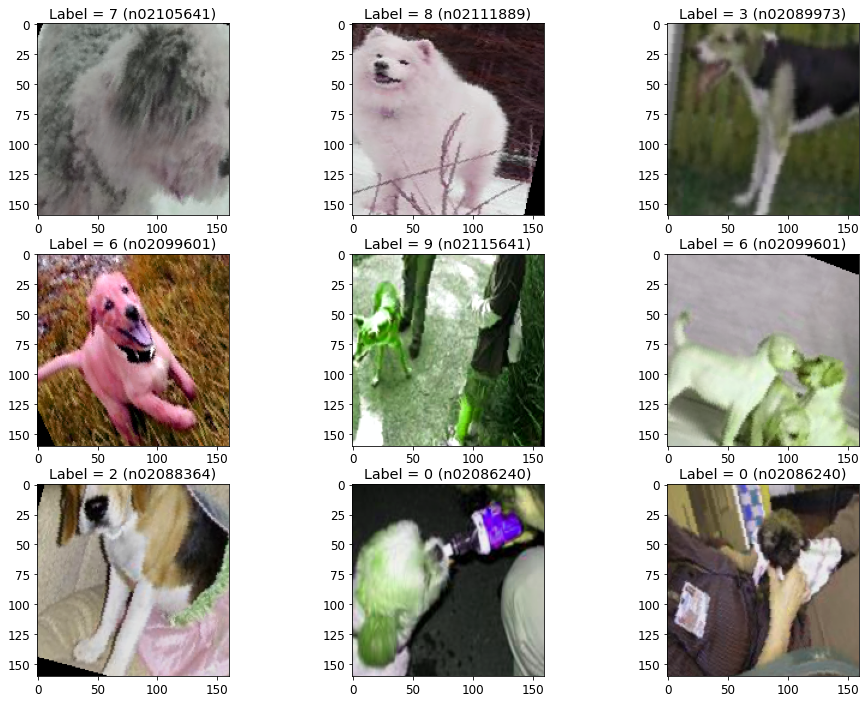

In [28]:
plot_from_batch_generator(train_aug_batch_gen)

## Training

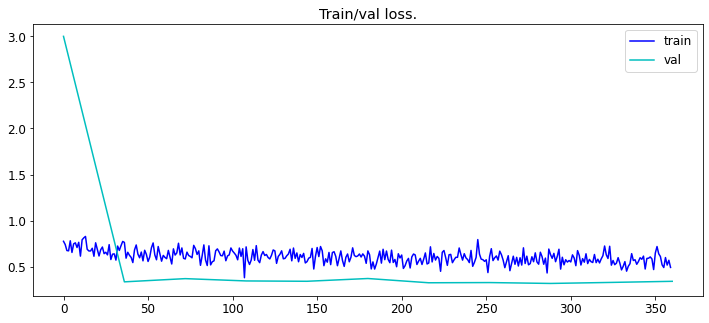

validation loss 1:  0.335
validation loss 2:  0.37
validation loss 3:  0.345
validation loss 4:  0.341
validation loss 5:  0.371
validation loss 6:  0.325
validation loss 7:  0.327
validation loss 8:  0.318
validation loss 9:  0.329
validation loss 10:  0.341
Epoch 10 of 10 took 92.564s


In [29]:
# Observe that only parameters of final layer are being optimized as opposed to before
opt_resnet = torch.optim.Adam(model_resnext50.fc.parameters(), lr=1e-3)
ckpt_name_resnext50='model_resnext50_finetune.ckpt'

model_resnext50, opt_resnet = train_model(model_resnext50, train_aug_batch_gen, val_batch_gen, opt_resnet,
                                         ckpt_name=ckpt_name_resnext50, n_epochs=10)

In [30]:
best_model_resnext50_aug=None
with open(ckpt_name_resnext50, 'rb') as f:
    best_model_resnext50 = torch.load(f)

val_stats = test_model(best_model_resnext50, val_batch_gen, 'val')

Results on val set | accuracy: 0.8928 | f1-score: 0.8886
